In [103]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from collections import  defaultdict

# preprocessing 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import classification_report, accuracy_score

# models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    HistGradientBoostingClassifier
)

# scripts
from src.wrapped import Wrapped
from src.analysesV02 import Analytics
from src.trainV02 import TrainModels 

# Importar dados

In [104]:
ac = Analytics()
tm = TrainModels()
wp = Wrapped(
    '../data/row/',
    '../data/processed/',
    '../data/files/'
)

In [105]:
# dataset
df = wp.load_data('df_instrumentos_features_selecionadas').drop(columns=['file_name'])
df.columns

Index(['tonnetz0', 'tonnetz1', 'chroma1', 'chroma2', 'chroma3', 'chroma4',
       'chroma5', 'chroma6', 'chroma7', 'mfcc0', 'mfcc1', 'mfcc2', 'mfcc3',
       'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10',
       'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17',
       'mfcc18', 'mfcc19', 'chroma8', 'chroma9', 'chroma10', 'chroma11',
       'chroma12', 'spectral_band2', 'spectral_band3', 'spectral_band4',
       'spectral_centroid', 'spectral_onset', 'spectral_rolloff', 'spectogram',
       'mel_spectogram', 'zero_crossing_rate', 'zero_crossing', 'instrumento'],
      dtype='object')

# Pré Processamento

In [106]:
le = LabelEncoder()

df['label_inst'] = le.fit_transform(df.instrumento)
df.head()

,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,mfcc0,...,spectral_band4,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst
0,0.010380,0.038218,0.513887,0.581963,0.434641,0.293949,0.317826,0.271148,0.548258,-24.170067,...,3409.640722,2600.055158,1.098243,5260.821321,-44.640682,-30.202150,0.149672,33095,accordion,0
1,0.084643,-0.035337,0.175587,0.429345,0.840043,0.384524,0.282545,0.346341,0.482365,-90.556145,...,3516.595715,2385.271420,1.360742,5225.124166,-46.575737,-59.323132,0.112181,24785,accordion,0
2,-0.030127,0.082404,0.453814,0.219808,0.228484,0.446050,0.178916,0.250981,0.327460,-106.124260,...,3256.491175,2069.850731,1.343197,4287.155824,-56.276707,-71.512909,0.096007,21230,accordion,0
3,0.157274,-0.066099,0.209729,0.338755,0.660264,0.256625,0.275209,0.180417,0.399448,-66.319801,...,3855.791675,2903.979876,1.218963,6751.133809,-42.723160,-44.649315,0.144010,31836,accordion,0
4,-0.049096,-0.029067,0.484400,0.334572,0.441629,0.679485,0.382958,0.326033,0.205775,-226.263824,...,2883.225952,1251.374287,1.339527,2263.034730,-62.227947,-78.196365,0.059804,13214,accordion,0


In [27]:
# ver classe por instrumento 
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
print(dictionary)

{'accordion': 0, 'banjo': 1, 'bass': 2, 'cello': 3, 'clarinet': 4, 'cymbals': 5, 'drums': 6, 'flute': 7, 'guitar': 8, 'mallet_percussion': 9, 'mandolin': 10, 'organ': 11, 'piano': 12, 'saxophone': 13, 'synthesizer': 14, 'trombone': 15, 'trumpet': 16, 'ukulele': 17, 'violin': 18, 'voice': 19}


#### instrumentos por classe
- corda: cello, guitar, violin, bass, banjo, mandolin e ukulele
- percusao: mallet_percussion, drums e cymbals
- sopro: clarinet, trombone, flute, trumpet, saxophone
- aerofone: accordion, organ, piano 

In [44]:
dict_cat_inst = {
    'aerofone': ["accordion", "organ", "piano"],
    'percusao': ["mallet_percussion", "drums", "cymbals"],
    'sopro': ["clarinet", "trombone", "flute", "trumpet", "saxophone"],
    'corda': ["cello", "guitar", "violin", "bass", "banjo", "mandolin", "ukulele"]
}

In [45]:
df_aerofone = df[df['instrumento'].isin(dict_cat_inst['aerofone'])]
df_aerofone.insert(0, 'cat_inst', 'aerofone')

df_percusao = df[df['instrumento'].isin(dict_cat_inst['percusao'])]
df_percusao.insert(0, 'cat_inst', 'percusao')

df_sopro = df[df['instrumento'].isin(dict_cat_inst['sopro'])]
df_sopro.insert(0, 'cat_inst', 'sopro')

df_corda = df[df['instrumento'].isin(dict_cat_inst['corda'])]
df_corda.insert(0, 'cat_inst', 'corda')

df_cat_inst = pd.concat([df_aerofone, df_percusao, df_sopro, df_corda])
df_cat_inst

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_band4,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst
0,aerofone,0.010380,0.038218,0.513887,0.581963,0.434641,0.293949,0.317826,0.271148,0.548258,...,3409.640722,2600.055158,1.098243,5260.821321,-44.640682,-30.202150,0.149672,33095,accordion,0
1,aerofone,0.084643,-0.035337,0.175587,0.429345,0.840043,0.384524,0.282545,0.346341,0.482365,...,3516.595715,2385.271420,1.360742,5225.124166,-46.575737,-59.323132,0.112181,24785,accordion,0
2,aerofone,-0.030127,0.082404,0.453814,0.219808,0.228484,0.446050,0.178916,0.250981,0.327460,...,3256.491175,2069.850731,1.343197,4287.155824,-56.276707,-71.512909,0.096007,21230,accordion,0
3,aerofone,0.157274,-0.066099,0.209729,0.338755,0.660264,0.256625,0.275209,0.180417,0.399448,...,3855.791675,2903.979876,1.218963,6751.133809,-42.723160,-44.649315,0.144010,31836,accordion,0
4,aerofone,-0.049096,-0.029067,0.484400,0.334572,0.441629,0.679485,0.382958,0.326033,0.205775,...,2883.225952,1251.374287,1.339527,2263.034730,-62.227947,-78.196365,0.059804,13214,accordion,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8019,corda,0.051950,0.691044,0.773323,0.582712,0.532384,0.274606,0.127275,0.109617,0.158079,...,1906.686246,658.017342,1.227272,1367.932950,-35.302883,-68.164001,0.019043,4212,violin,18
8020,corda,0.015595,-0.058762,0.120028,0.238263,0.234643,0.267743,0.228591,0.260930,0.267262,...,3383.563150,3573.542978,1.354204,6552.813508,-43.596504,-73.498703,0.230540,50962,violin,18
8021,corda,0.093624,-0.031124,0.253249,0.321181,0.309254,0.265595,0.265015,0.155659,0.181344,...,3174.287104,1421.358194,1.173742,2751.578644,-48.512993,-66.277359,0.065123,14407,violin,18
8022,corda,0.004588,-0.009204,0.124913,0.174113,0.185558,0.169614,0.149416,0.075544,0.081894,...,3232.221409,3720.081212,1.332893,6207.732687,-37.720039,-72.552101,0.241853,53491,violin,18


In [46]:
print('Sem voice e synthesizer:', df.shape[0] -  (df[df.instrumento == 'voice'].shape[0] + df[df.instrumento == 'synthesizer'].shape[0]))

Sem voice e synthesizer: 7649


In [47]:
df_cat_inst['label_cat_inst'] = le.fit_transform(df_cat_inst.cat_inst)
df_cat_inst

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst,label_cat_inst
0,aerofone,0.010380,0.038218,0.513887,0.581963,0.434641,0.293949,0.317826,0.271148,0.548258,...,2600.055158,1.098243,5260.821321,-44.640682,-30.202150,0.149672,33095,accordion,0,0
1,aerofone,0.084643,-0.035337,0.175587,0.429345,0.840043,0.384524,0.282545,0.346341,0.482365,...,2385.271420,1.360742,5225.124166,-46.575737,-59.323132,0.112181,24785,accordion,0,0
2,aerofone,-0.030127,0.082404,0.453814,0.219808,0.228484,0.446050,0.178916,0.250981,0.327460,...,2069.850731,1.343197,4287.155824,-56.276707,-71.512909,0.096007,21230,accordion,0,0
3,aerofone,0.157274,-0.066099,0.209729,0.338755,0.660264,0.256625,0.275209,0.180417,0.399448,...,2903.979876,1.218963,6751.133809,-42.723160,-44.649315,0.144010,31836,accordion,0,0
4,aerofone,-0.049096,-0.029067,0.484400,0.334572,0.441629,0.679485,0.382958,0.326033,0.205775,...,1251.374287,1.339527,2263.034730,-62.227947,-78.196365,0.059804,13214,accordion,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8019,corda,0.051950,0.691044,0.773323,0.582712,0.532384,0.274606,0.127275,0.109617,0.158079,...,658.017342,1.227272,1367.932950,-35.302883,-68.164001,0.019043,4212,violin,18,1
8020,corda,0.015595,-0.058762,0.120028,0.238263,0.234643,0.267743,0.228591,0.260930,0.267262,...,3573.542978,1.354204,6552.813508,-43.596504,-73.498703,0.230540,50962,violin,18,1
8021,corda,0.093624,-0.031124,0.253249,0.321181,0.309254,0.265595,0.265015,0.155659,0.181344,...,1421.358194,1.173742,2751.578644,-48.512993,-66.277359,0.065123,14407,violin,18,1
8022,corda,0.004588,-0.009204,0.124913,0.174113,0.185558,0.169614,0.149416,0.075544,0.081894,...,3720.081212,1.332893,6207.732687,-37.720039,-72.552101,0.241853,53491,violin,18,1


# Baseline

- Remover Outliers

In [48]:
knn_pred_cat_inst = ac.detected_outilers_knn(dataframe=df_cat_inst, neighbors=5, algorithm="auto", metric="euclidean")

- Plot

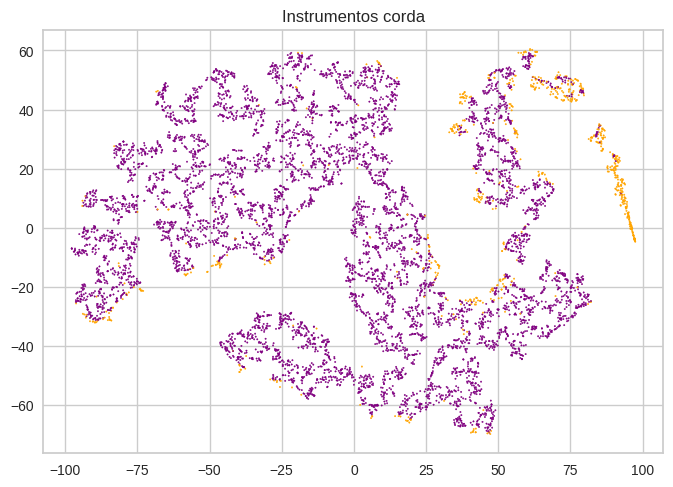

In [49]:
ac.graphic_anomalies(df_cat_inst, knn_pred_cat_inst["predictions"],'Instrumentos corda')

In [50]:
# remover outilers do dataframe
new_df = ac.show_outilers(df_cat_inst, knn_pred_cat_inst["predictions"])
new_df

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst,label_cat_inst
28,aerofone,0.177880,0.099179,0.446227,0.186154,0.310970,0.289374,0.480033,0.271526,0.262448,...,3178.625677,1.504104,5658.636007,-64.840324,-79.991013,0.225914,49936,accordion,0,0
46,aerofone,0.001389,0.058207,0.307783,0.359920,0.321503,0.340189,0.230577,0.230887,0.267941,...,3317.306522,1.480623,6072.413242,-37.332355,-79.453758,0.249911,55267,accordion,0,0
78,aerofone,0.092169,0.133666,0.193358,0.281352,0.774958,0.293572,0.316613,0.302946,0.372028,...,2105.938025,1.162251,3689.097337,-49.523079,-69.013954,0.146228,32336,accordion,0,0
92,aerofone,0.097079,0.012940,0.456796,0.240604,0.184937,0.265562,0.233346,0.257924,0.365673,...,2515.943118,1.157362,4664.186723,-53.163174,-42.839451,0.127483,28181,accordion,0,0
101,aerofone,-0.083369,0.002492,0.365614,0.188457,0.210712,0.340728,0.218881,0.389993,0.138017,...,2495.492458,1.521361,4334.344015,-64.275818,-79.999847,0.203175,44935,accordion,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7997,corda,0.320206,-0.085033,0.041392,0.211963,0.408310,0.136639,0.086331,0.054177,0.200026,...,2402.051002,1.037037,4183.361788,-56.639145,-79.900841,0.172518,38109,violin,18,1
7999,corda,0.188614,-0.123051,0.435805,0.078954,0.048469,0.095815,0.166382,0.088318,0.250419,...,1772.864514,1.268380,2945.977004,-76.595161,-80.000000,0.126178,27872,violin,18,1
8017,corda,0.096697,-0.279816,0.159033,0.078111,0.079078,0.180735,0.292732,0.125269,0.363708,...,2277.244488,1.186836,3779.127109,-50.537724,-80.000000,0.143759,31806,violin,18,1
8020,corda,0.015595,-0.058762,0.120028,0.238263,0.234643,0.267743,0.228591,0.260930,0.267262,...,3573.542978,1.354204,6552.813508,-43.596504,-73.498703,0.230540,50962,violin,18,1


- Split

In [51]:
X = new_df.drop(columns=["label_inst", "label_cat_inst", "cat_inst", "instrumento"])
y = new_df.label_cat_inst

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

- Treinamento

In [52]:
model = HistGradientBoostingClassifier()
model.fit(X_train, y_train)
predict = model.predict(X_test)
print(f'Acuracia {model}: {accuracy_score(y_test, predict)}')

Acuracia HistGradientBoostingClassifier(): 0.45652173913043476


- Validação Cruzada

In [53]:
models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    MLPClassifier(),
    LGBMClassifier(),
    XGBClassifier()
])

tm.train_models(
    X = new_df.drop(columns=["label_inst", "label_cat_inst", "cat_inst", "instrumento"]),
    y = new_df.label_cat_inst,
    models=models
)

Acuracia do modelo GaussianNB() do Fold 0: 0.46405228758169936
Acuracia do modelo GaussianNB() do Fold 1: 0.4444444444444444
Acuracia do modelo GaussianNB() do Fold 2: 0.5294117647058824
Acuracia do modelo GaussianNB() do Fold 3: 0.42483660130718953
Acuracia do modelo GaussianNB() do Fold 4: 0.19607843137254902
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.3790849673202614
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.40522875816993464
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.38562091503267976
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.4117647058823529
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.28104575163398693
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.35294117647058826
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.35947712418300654
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.43790849673202614
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.35294117647058826
Acuracia do modelo Decis

{'GaussianNB': 0.3902894491129785,
 'KNeighborsClassifier': 0.38807189542483655,
 'DecisionTreeClassifier': 0.3822803195352214,
 'RandomForestClassifier': 0.39333333333333337,
 'HistGradientBoostingClassifier': 0.39809863339275103,
 'MLPClassifier': 0.38965141612200427,
 'LGBMClassifier': 0.3961789844142785,
 'XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n              interaction_constraints=None, learning_rate=None, max_bin=None,\n              max_cat_threshold=None, max_cat_to_onehot=None,\n              max_delta_step=None, max_depth=None, max_leaves=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_p

- Matriz de Confusão

In [55]:
# ver classe por categoria instrumento 
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
print(dictionary)

{'aerofone': 0, 'corda': 1, 'percusao': 2, 'sopro': 3}


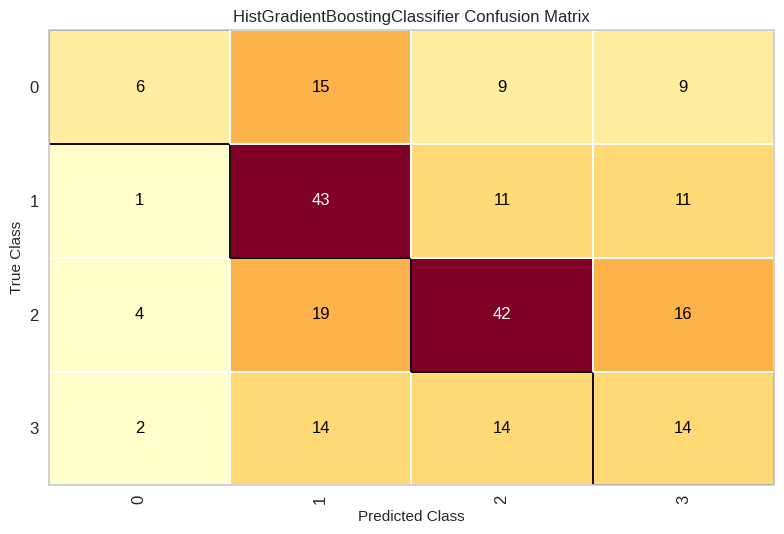

<Axes: title={'center': 'HistGradientBoostingClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [56]:
cm = ConfusionMatrix(model, classes=[0,1,2,3])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

cm.show()

obs:. Pelos numeros da validação cruzada percebe a dificuldade não dizer quando se tem por exemplo um instrumento de corda mas sim quando não tem um instrumento de corda

In [57]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.46      0.15      0.23        39
           1       0.47      0.65      0.55        66
           2       0.55      0.52      0.54        81
           3       0.28      0.32      0.30        44

    accuracy                           0.46       230
   macro avg       0.44      0.41      0.40       230
weighted avg       0.46      0.46      0.44       230



# Experiementos com instrumentos par a par

### Combinação em par de categorias de instrumentos:

- aerofone e corda
- aerofone e sopro
- aerofone e percusão
- sopro e percusão
- sopro e corda
- percusão e corda

### Aerofone e corda

In [58]:
df_aerofone_corda = df_cat_inst[df_cat_inst["cat_inst"].isin(["aerofone", "corda"])]
df_aerofone_corda["label_cat_inst"] = le.fit_transform(df_aerofone_corda.cat_inst)
df_aerofone_corda

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst,label_cat_inst
0,aerofone,0.010380,0.038218,0.513887,0.581963,0.434641,0.293949,0.317826,0.271148,0.548258,...,2600.055158,1.098243,5260.821321,-44.640682,-30.202150,0.149672,33095,accordion,0,0
1,aerofone,0.084643,-0.035337,0.175587,0.429345,0.840043,0.384524,0.282545,0.346341,0.482365,...,2385.271420,1.360742,5225.124166,-46.575737,-59.323132,0.112181,24785,accordion,0,0
2,aerofone,-0.030127,0.082404,0.453814,0.219808,0.228484,0.446050,0.178916,0.250981,0.327460,...,2069.850731,1.343197,4287.155824,-56.276707,-71.512909,0.096007,21230,accordion,0,0
3,aerofone,0.157274,-0.066099,0.209729,0.338755,0.660264,0.256625,0.275209,0.180417,0.399448,...,2903.979876,1.218963,6751.133809,-42.723160,-44.649315,0.144010,31836,accordion,0,0
4,aerofone,-0.049096,-0.029067,0.484400,0.334572,0.441629,0.679485,0.382958,0.326033,0.205775,...,1251.374287,1.339527,2263.034730,-62.227947,-78.196365,0.059804,13214,accordion,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8019,corda,0.051950,0.691044,0.773323,0.582712,0.532384,0.274606,0.127275,0.109617,0.158079,...,658.017342,1.227272,1367.932950,-35.302883,-68.164001,0.019043,4212,violin,18,1
8020,corda,0.015595,-0.058762,0.120028,0.238263,0.234643,0.267743,0.228591,0.260930,0.267262,...,3573.542978,1.354204,6552.813508,-43.596504,-73.498703,0.230540,50962,violin,18,1
8021,corda,0.093624,-0.031124,0.253249,0.321181,0.309254,0.265595,0.265015,0.155659,0.181344,...,1421.358194,1.173742,2751.578644,-48.512993,-66.277359,0.065123,14407,violin,18,1
8022,corda,0.004588,-0.009204,0.124913,0.174113,0.185558,0.169614,0.149416,0.075544,0.081894,...,3720.081212,1.332893,6207.732687,-37.720039,-72.552101,0.241853,53491,violin,18,1


- Tratar outilers

In [60]:
outilers_aerofone_corda  = ac.detected_outilers_knn(
    dataframe=df_aerofone_corda,
    algorithm='auto', 
    neighbors=5, 
    metric='euclidean'
)

df_aerofone_corda = ac.show_outilers(
    dataframe=df_aerofone_corda,
    pred=outilers_aerofone_corda['predictions']
)

df_aerofone_corda

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst,label_cat_inst
3,aerofone,0.157274,-0.066099,0.209729,0.338755,0.660264,0.256625,0.275209,0.180417,0.399448,...,2903.979876,1.218963,6751.133809,-42.723160,-44.649315,0.144010,31836,accordion,0,0
28,aerofone,0.177880,0.099179,0.446227,0.186154,0.310970,0.289374,0.480033,0.271526,0.262448,...,3178.625677,1.504104,5658.636007,-64.840324,-79.991013,0.225914,49936,accordion,0,0
46,aerofone,0.001389,0.058207,0.307783,0.359920,0.321503,0.340189,0.230577,0.230887,0.267941,...,3317.306522,1.480623,6072.413242,-37.332355,-79.453758,0.249911,55267,accordion,0,0
60,aerofone,0.003770,0.069227,0.157029,0.264191,0.612490,0.513482,0.283783,0.279843,0.223590,...,3223.649221,1.543456,6539.049245,-47.371098,-56.212872,0.160451,35507,accordion,0,0
68,aerofone,0.315369,0.119436,0.165054,0.304648,0.831039,0.422758,0.297391,0.241401,0.206774,...,2902.618765,1.674287,5889.156191,-42.290485,-77.100327,0.123588,27331,accordion,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7999,corda,0.188614,-0.123051,0.435805,0.078954,0.048469,0.095815,0.166382,0.088318,0.250419,...,1772.864514,1.268380,2945.977004,-76.595161,-80.000000,0.126178,27872,violin,18,1
8016,corda,0.066705,-0.239727,0.177657,0.249958,0.202065,0.227559,0.358576,0.191313,0.535777,...,2049.088272,1.239214,3472.241494,-45.379463,-80.000000,0.128462,28414,violin,18,1
8017,corda,0.096697,-0.279816,0.159033,0.078111,0.079078,0.180735,0.292732,0.125269,0.363708,...,2277.244488,1.186836,3779.127109,-50.537724,-80.000000,0.143759,31806,violin,18,1
8020,corda,0.015595,-0.058762,0.120028,0.238263,0.234643,0.267743,0.228591,0.260930,0.267262,...,3573.542978,1.354204,6552.813508,-43.596504,-73.498703,0.230540,50962,violin,18,1


- Treinamento de modelo

In [62]:
list_models = np.array([
    LGBMClassifier(),
    XGBClassifier(),
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    MLPClassifier()
])

tm.train_models(
    X= df_aerofone_corda.drop(columns=['instrumento','label_inst', 'label_cat_inst','cat_inst']),
    y= df_aerofone_corda['label_cat_inst'],
    models=list_models
)

Acuracia do modelo LGBMClassifier() do Fold 0: 0.5222222222222223
Acuracia do modelo LGBMClassifier() do Fold 1: 0.5888888888888889
Acuracia do modelo LGBMClassifier() do Fold 2: 0.6333333333333333
Acuracia do modelo LGBMClassifier() do Fold 3: 0.7333333333333333
Acuracia do modelo LGBMClassifier() do Fold 4: 0.6179775280898876
Acuracia do modelo XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estima

{'LGBMClassifier': 0.4567772777025917,
 'XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n              interaction_constraints=None, learning_rate=None, max_bin=None,\n              max_cat_threshold=None, max_cat_to_onehot=None,\n              max_delta_step=None, max_depth=None, max_leaves=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=None, ..': 0.46497052481189965,
 'GaussianNB': 0.46565546264100827,
 'KNeighborsClassifier': 0.469819527061761,
 'DecisionTreeClassifier': 0.47312312550488367,
 'RandomForestClassifier': 0.4786560351596703,
 

- Matrix de Confusão

In [63]:
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
print(dictionary)

{'aerofone': 0, 'corda': 1}


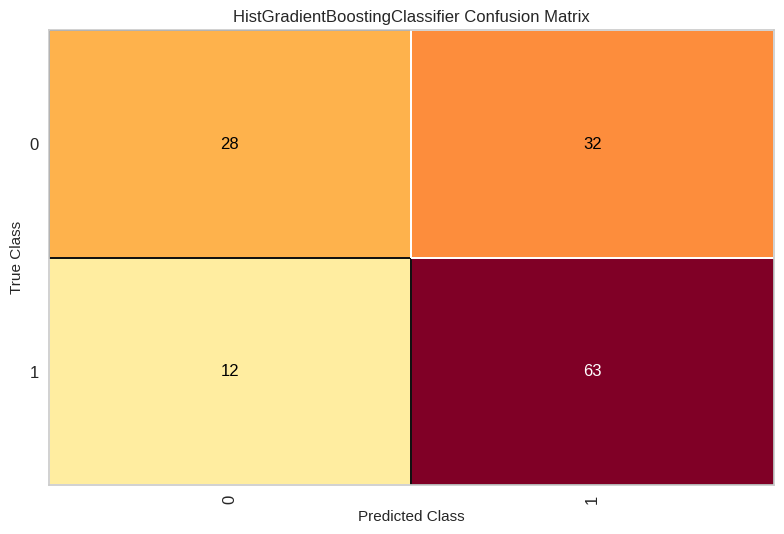

<Axes: title={'center': 'HistGradientBoostingClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [64]:
X = df_aerofone_corda.drop(columns=["cat_inst","label_inst", "label_cat_inst", 'instrumento'])
y = df_aerofone_corda.label_cat_inst

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cm = ConfusionMatrix(HistGradientBoostingClassifier(),classes=[0,1])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

### Aerofone e sopro

In [67]:
df_aerofone_sopro = df_cat_inst[df_cat_inst["cat_inst"].isin(["aerofone", "sopro"])]
df_aerofone_sopro["label_cat_inst"] = le.fit_transform(df_aerofone_sopro.cat_inst)
df_aerofone_sopro

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst,label_cat_inst
0,aerofone,0.010380,0.038218,0.513887,0.581963,0.434641,0.293949,0.317826,0.271148,0.548258,...,2600.055158,1.098243,5260.821321,-44.640682,-30.202150,0.149672,33095,accordion,0,0
1,aerofone,0.084643,-0.035337,0.175587,0.429345,0.840043,0.384524,0.282545,0.346341,0.482365,...,2385.271420,1.360742,5225.124166,-46.575737,-59.323132,0.112181,24785,accordion,0,0
2,aerofone,-0.030127,0.082404,0.453814,0.219808,0.228484,0.446050,0.178916,0.250981,0.327460,...,2069.850731,1.343197,4287.155824,-56.276707,-71.512909,0.096007,21230,accordion,0,0
3,aerofone,0.157274,-0.066099,0.209729,0.338755,0.660264,0.256625,0.275209,0.180417,0.399448,...,2903.979876,1.218963,6751.133809,-42.723160,-44.649315,0.144010,31836,accordion,0,0
4,aerofone,-0.049096,-0.029067,0.484400,0.334572,0.441629,0.679485,0.382958,0.326033,0.205775,...,1251.374287,1.339527,2263.034730,-62.227947,-78.196365,0.059804,13214,accordion,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7161,sopro,0.031326,0.036042,0.281165,0.467478,0.383710,0.385898,0.358991,0.379168,0.286116,...,896.653459,1.242603,1782.859289,-42.632786,-42.830780,0.041767,9231,trumpet,16,1
7162,sopro,0.024069,-0.064162,0.038717,0.051984,0.156484,0.528343,0.865360,0.228249,0.063890,...,1280.731144,1.535133,1930.644010,-52.891537,-79.643761,0.078466,17360,trumpet,16,1
7163,sopro,0.046916,0.068088,0.517141,0.282860,0.547268,0.444383,0.516097,0.406917,0.322084,...,2309.708871,1.049440,5199.019529,-37.911655,-57.435429,0.095421,21114,trumpet,16,1
7164,sopro,0.109233,0.002179,0.271734,0.290186,0.454663,0.332584,0.266866,0.341721,0.481044,...,2370.998419,1.259253,5153.205266,-53.025776,-79.120621,0.126226,27933,trumpet,16,1


- Tratar outilers

In [71]:
outilers_aerofone_sopro  = ac.detected_outilers_knn(
    dataframe=df_aerofone_sopro,
    algorithm='auto', 
    neighbors=5, 
    metric='euclidean'
)

df_aerofone_sopro = ac.show_outilers(
    dataframe=df_aerofone_sopro,
    pred=outilers_aerofone_sopro['predictions']
)

df_aerofone_sopro

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst,label_cat_inst
28,aerofone,0.177880,0.099179,0.446227,0.186154,0.310970,0.289374,0.480033,0.271526,0.262448,...,3178.625677,1.504104,5658.636007,-64.840324,-79.991013,0.225914,49936,accordion,0,0
46,aerofone,0.001389,0.058207,0.307783,0.359920,0.321503,0.340189,0.230577,0.230887,0.267941,...,3317.306522,1.480623,6072.413242,-37.332355,-79.453758,0.249911,55267,accordion,0,0
60,aerofone,0.003770,0.069227,0.157029,0.264191,0.612490,0.513482,0.283783,0.279843,0.223590,...,3223.649221,1.543456,6539.049245,-47.371098,-56.212872,0.160451,35507,accordion,0,0
78,aerofone,0.092169,0.133666,0.193358,0.281352,0.774958,0.293572,0.316613,0.302946,0.372028,...,2105.938025,1.162251,3689.097337,-49.523079,-69.013954,0.146228,32336,accordion,0,0
93,aerofone,-0.002144,-0.008803,0.449169,0.438542,0.488127,0.524772,0.491166,0.454427,0.469509,...,3152.126942,1.361253,6306.830386,-32.494141,-51.824329,0.183488,40554,accordion,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7153,sopro,0.095131,0.165130,0.409808,0.178644,0.131329,0.086917,0.195207,0.238547,0.105908,...,1466.013189,1.140587,2337.326779,-75.481300,-79.999992,0.101459,22454,trumpet,16,1
7154,sopro,-0.029138,0.004838,0.534387,0.545401,0.223559,0.374719,0.498750,0.877884,0.388922,...,1776.745728,1.295782,3109.524430,-46.688988,-58.327690,0.127745,28264,trumpet,16,1
7156,sopro,-0.148693,0.003055,0.543909,0.820975,0.261659,0.262984,0.201507,0.296120,0.160154,...,2612.295812,0.958099,4009.572352,-64.094101,-80.000000,0.170468,37702,trumpet,16,1
7159,sopro,-0.040215,0.031151,0.587902,0.642199,0.661011,0.675489,0.697853,0.718583,0.482416,...,285.508118,0.854189,403.660127,-16.440603,-14.334520,0.014532,3213,trumpet,16,1


- Treinamento de Modelo

In [73]:
list_models = np.array([
    LGBMClassifier(),
    XGBClassifier(),
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    MLPClassifier()
])

tm.train_models(
    X= df_aerofone_sopro.drop(columns=['instrumento','label_inst', 'label_cat_inst','cat_inst']),
    y= df_aerofone_sopro['label_cat_inst'],
    models=list_models
)

Acuracia do modelo LGBMClassifier() do Fold 0: 0.6764705882352942
Acuracia do modelo LGBMClassifier() do Fold 1: 0.6567164179104478
Acuracia do modelo LGBMClassifier() do Fold 2: 0.6865671641791045
Acuracia do modelo LGBMClassifier() do Fold 3: 0.7014925373134329
Acuracia do modelo LGBMClassifier() do Fold 4: 0.5373134328358209
Acuracia do modelo XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estima

{'LGBMClassifier': 0.4904615748736168,
 'XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n              interaction_constraints=None, learning_rate=None, max_bin=None,\n              max_cat_threshold=None, max_cat_to_onehot=None,\n              max_delta_step=None, max_depth=None, max_leaves=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=None, ..': 0.49583512670911434,
 'GaussianNB': 0.49884976294005606,
 'KNeighborsClassifier': 0.5008405476199089,
 'DecisionTreeClassifier': 0.5042524351411509,
 'RandomForestClassifier': 0.5086798605497711,
 

In [74]:
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
print(dictionary)

{'aerofone': 0, 'sopro': 1}


- Matriz de confusão

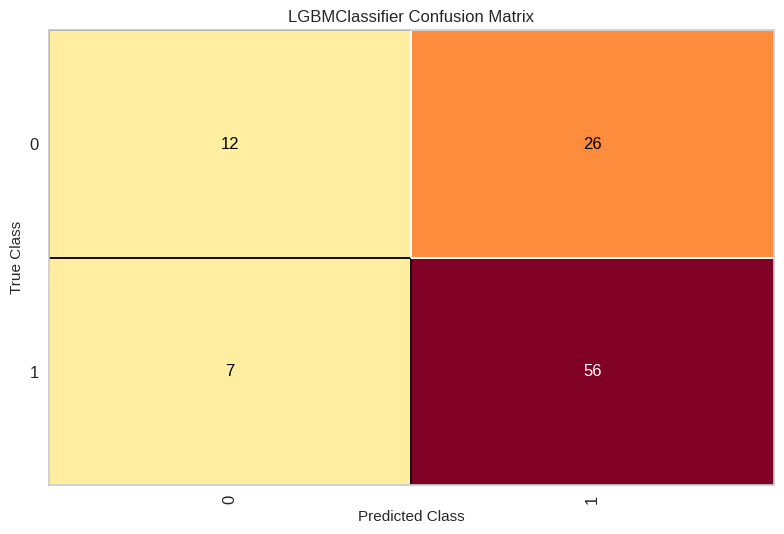

<Axes: title={'center': 'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [76]:
X = df_aerofone_sopro.drop(columns=["label_inst", "label_cat_inst", "cat_inst", "instrumento"])
y = df_aerofone_sopro.label_cat_inst

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cm = ConfusionMatrix(LGBMClassifier(), classes=[0,1])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

### Aerofone e percusão

In [77]:
df_aerofone_percusao = df_cat_inst[df_cat_inst["cat_inst"].isin(["aerofone", "percusao"])]
df_aerofone_percusao["label_cat_inst"] = le.fit_transform(df_aerofone_percusao.cat_inst)
df_aerofone_percusao

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst,label_cat_inst
0,aerofone,0.010380,0.038218,0.513887,0.581963,0.434641,0.293949,0.317826,0.271148,0.548258,...,2600.055158,1.098243,5260.821321,-44.640682,-30.202150,0.149672,33095,accordion,0,0
1,aerofone,0.084643,-0.035337,0.175587,0.429345,0.840043,0.384524,0.282545,0.346341,0.482365,...,2385.271420,1.360742,5225.124166,-46.575737,-59.323132,0.112181,24785,accordion,0,0
2,aerofone,-0.030127,0.082404,0.453814,0.219808,0.228484,0.446050,0.178916,0.250981,0.327460,...,2069.850731,1.343197,4287.155824,-56.276707,-71.512909,0.096007,21230,accordion,0,0
3,aerofone,0.157274,-0.066099,0.209729,0.338755,0.660264,0.256625,0.275209,0.180417,0.399448,...,2903.979876,1.218963,6751.133809,-42.723160,-44.649315,0.144010,31836,accordion,0,0
4,aerofone,-0.049096,-0.029067,0.484400,0.334572,0.441629,0.679485,0.382958,0.326033,0.205775,...,1251.374287,1.339527,2263.034730,-62.227947,-78.196365,0.059804,13214,accordion,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4581,percusao,0.064085,0.031877,0.088719,0.110646,0.159631,0.303337,0.233713,0.293759,0.225420,...,1950.192940,1.101535,2585.158459,-50.985691,-72.046715,0.160147,35457,mallet_percussion,9,1
4582,percusao,0.264473,-0.245898,0.214395,0.094173,0.177360,0.087018,0.063969,0.138096,0.353633,...,1984.641346,1.996110,4595.240504,-66.942772,-78.150574,0.064426,14272,mallet_percussion,9,1
4583,percusao,0.087865,-0.048417,0.321572,0.221088,0.240128,0.374176,0.547956,0.418325,0.338949,...,3307.151107,1.378473,6980.305045,-56.667892,-75.132233,0.158234,35032,mallet_percussion,9,1
4584,percusao,0.432549,0.102409,0.204631,0.283638,0.785254,0.440283,0.356656,0.148266,0.208002,...,1533.762409,1.141370,2913.027706,-68.506294,-79.922241,0.079375,17537,mallet_percussion,9,1


- Tratar Outilers

In [78]:
outilers_aerofone_percusao  = ac.detected_outilers_knn(
    dataframe=df_aerofone_percusao,
    algorithm='auto', 
    neighbors=5, 
    metric='euclidean'
)

df_aerofone_percusao = ac.show_outilers(
    dataframe=df_aerofone_percusao,
    pred=outilers_aerofone_percusao['predictions']
)

df_aerofone_percusao

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst,label_cat_inst
28,aerofone,0.177880,0.099179,0.446227,0.186154,0.310970,0.289374,0.480033,0.271526,0.262448,...,3178.625677,1.504104,5658.636007,-64.840324,-79.991013,0.225914,49936,accordion,0,0
101,aerofone,-0.083369,0.002492,0.365614,0.188457,0.210712,0.340728,0.218881,0.389993,0.138017,...,2495.492458,1.521361,4334.344015,-64.275818,-79.999847,0.203175,44935,accordion,0,0
102,aerofone,0.304000,0.122806,0.350294,0.218089,0.486672,0.214657,0.331902,0.073321,0.085603,...,3408.975053,1.338741,6270.983349,-78.413834,-80.000000,0.231030,51151,accordion,0,0
135,aerofone,0.023928,0.295064,0.578289,0.594822,0.568853,0.723615,0.453601,0.691517,0.612611,...,788.124857,0.801734,1317.872000,-0.801849,-2.722743,0.004142,966,accordion,0,0
137,aerofone,0.024385,0.039629,0.464126,0.419017,0.569746,0.737048,0.675182,0.382305,0.338771,...,4383.260067,0.988195,8659.220415,-55.435081,-64.208626,0.376119,83194,accordion,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4561,percusao,0.305108,-0.047513,0.147523,0.121128,0.047512,0.028472,0.247569,0.205764,0.088979,...,2511.562704,1.421833,5474.379736,-47.792496,-70.003914,0.146273,32362,mallet_percussion,9,1
4573,percusao,0.424326,-0.240209,0.127338,0.211656,0.438093,0.604280,0.843284,0.976121,0.586622,...,283.995303,0.419410,510.951435,-62.118206,-73.764893,0.012129,2688,mallet_percussion,9,1
4577,percusao,0.348110,0.159918,0.278293,0.092337,0.303201,0.065521,0.185706,0.234855,0.103411,...,2264.087534,1.359796,3551.354782,-21.233885,-59.256969,0.166638,36868,mallet_percussion,9,1
4581,percusao,0.064085,0.031877,0.088719,0.110646,0.159631,0.303337,0.233713,0.293759,0.225420,...,1950.192940,1.101535,2585.158459,-50.985691,-72.046715,0.160147,35457,mallet_percussion,9,1


- Treinamento de Modelo

In [79]:
list_models = np.array([
    LGBMClassifier(),
    XGBClassifier(),
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    MLPClassifier()
])

tm.train_models(
    X= df_aerofone_percusao.drop(columns=['instrumento','label_inst', 'label_cat_inst','cat_inst']),
    y= df_aerofone_percusao['label_cat_inst'],
    models=list_models
)

Acuracia do modelo LGBMClassifier() do Fold 0: 0.8059701492537313
Acuracia do modelo LGBMClassifier() do Fold 1: 0.8333333333333334
Acuracia do modelo LGBMClassifier() do Fold 2: 0.8333333333333334
Acuracia do modelo LGBMClassifier() do Fold 3: 0.7424242424242424
Acuracia do modelo LGBMClassifier() do Fold 4: 0.6666666666666666
Acuracia do modelo XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estima

{'LGBMClassifier': 0.5197030077452487,
 'XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n              interaction_constraints=None, learning_rate=None, max_bin=None,\n              max_cat_threshold=None, max_cat_to_onehot=None,\n              max_delta_step=None, max_depth=None, max_leaves=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=None, ..': 0.5262972690925225,
 'GaussianNB': 0.5316209622588173,
 'KNeighborsClassifier': 0.5374349158142872,
 'DecisionTreeClassifier': 0.5417860139945014,
 'RandomForestClassifier': 0.54729969152738,
 'His

In [80]:
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
print(dictionary)

{'aerofone': 0, 'percusao': 1}


- Matriz de Confusão

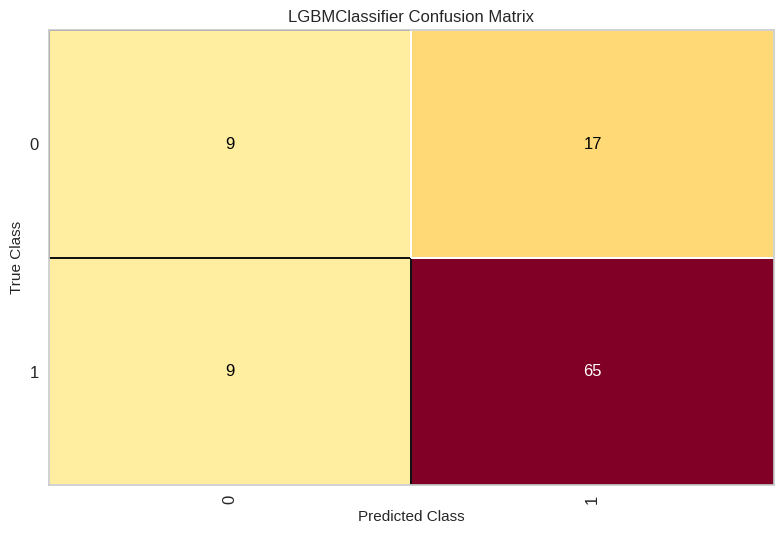

<Axes: title={'center': 'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [83]:
X = df_aerofone_percusao.drop(columns=["label_inst", "label_cat_inst", "cat_inst", "instrumento"])
y = df_aerofone_percusao.label_cat_inst

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cm = ConfusionMatrix(LGBMClassifier(), classes=[0,1])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

### Sopro e Percusão

In [84]:
df_sopro_percusao = df_cat_inst[df_cat_inst["cat_inst"].isin(["sopro", "percusao"])]
df_sopro_percusao["label_cat_inst"] = le.fit_transform(df_sopro_percusao.cat_inst)
df_sopro_percusao

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst,label_cat_inst
2027,percusao,0.040087,0.116203,0.409334,0.260820,0.298635,0.223068,0.472596,0.682380,0.315802,...,2843.107702,0.915473,6288.444728,-72.321693,-79.942192,0.106036,23418,cymbals,5,0
2028,percusao,0.064332,-0.023445,0.221986,0.318158,0.420399,0.800723,0.699277,0.292424,0.310495,...,2549.517812,1.755609,4183.087002,-47.144733,-65.961197,0.182486,40358,cymbals,5,0
2029,percusao,-0.039875,0.021506,0.597219,0.522248,0.357256,0.306705,0.454092,0.676822,0.459109,...,2543.370274,0.869033,4545.004690,-59.076328,-70.129898,0.152626,33743,cymbals,5,0
2030,percusao,-0.039822,0.028304,0.621655,0.511336,0.348413,0.316168,0.392748,0.568508,0.565586,...,2479.813426,1.396642,5702.476809,-63.114140,-71.209488,0.082574,18250,cymbals,5,0
2031,percusao,0.098013,0.027428,0.383891,0.186740,0.131834,0.186899,0.345623,0.210410,0.242533,...,2037.566496,1.731518,4412.483063,-56.386051,-59.750889,0.079232,17508,cymbals,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7161,sopro,0.031326,0.036042,0.281165,0.467478,0.383710,0.385898,0.358991,0.379168,0.286116,...,896.653459,1.242603,1782.859289,-42.632786,-42.830780,0.041767,9231,trumpet,16,1
7162,sopro,0.024069,-0.064162,0.038717,0.051984,0.156484,0.528343,0.865360,0.228249,0.063890,...,1280.731144,1.535133,1930.644010,-52.891537,-79.643761,0.078466,17360,trumpet,16,1
7163,sopro,0.046916,0.068088,0.517141,0.282860,0.547268,0.444383,0.516097,0.406917,0.322084,...,2309.708871,1.049440,5199.019529,-37.911655,-57.435429,0.095421,21114,trumpet,16,1
7164,sopro,0.109233,0.002179,0.271734,0.290186,0.454663,0.332584,0.266866,0.341721,0.481044,...,2370.998419,1.259253,5153.205266,-53.025776,-79.120621,0.126226,27933,trumpet,16,1


- Tratar outilers

In [85]:
outilers_sopro_percusao = ac.detected_outilers_knn(
    dataframe=df_sopro_percusao,
    algorithm='auto', 
    neighbors=5, 
    metric='euclidean'
)

df_sopro_percusao = ac.show_outilers(
    dataframe=df_sopro_percusao,
    pred=outilers_sopro_percusao['predictions']
)

df_sopro_percusao

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst,label_cat_inst
2058,percusao,0.028724,0.119361,0.387632,0.360637,0.641758,0.430467,0.488429,0.566602,0.417376,...,3368.580434,1.101028,7120.545651,-64.049034,-75.085358,0.179711,39714,cymbals,5,0
2066,percusao,0.067263,-0.079658,0.400289,0.414243,0.519233,0.403937,0.590723,0.326989,0.475230,...,3813.025950,1.273033,7134.060110,-47.323631,-62.697948,0.257473,56977,cymbals,5,0
2080,percusao,-0.028268,0.020594,0.308341,0.539134,0.486185,0.370537,0.365475,0.277279,0.237507,...,5631.779972,1.150056,8727.017531,-66.101967,-79.368797,0.486816,107670,cymbals,5,0
2084,percusao,0.090227,0.001803,0.181475,0.215828,0.223079,0.230837,0.477740,0.319292,0.496053,...,2887.785890,1.069310,5327.569254,-51.677456,-71.216888,0.188245,41621,cymbals,5,0
2087,percusao,0.000423,0.008728,0.315313,0.329236,0.318093,0.291647,0.358462,0.355331,0.340839,...,4034.598255,2.311115,7370.300831,-48.193481,-79.993744,0.275738,60975,cymbals,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7049,sopro,0.299879,0.026765,0.283813,0.178020,0.295542,0.277703,0.780676,0.233810,0.084910,...,985.032667,0.765431,1431.758164,-79.855415,-80.000000,0.066409,14678,trombone,15,1
7111,sopro,0.135470,0.111472,0.518805,0.231038,0.153544,0.142523,0.404127,0.336685,0.211471,...,1345.818619,0.946602,1966.715872,-78.892021,-80.000000,0.112739,24948,trumpet,16,1
7113,sopro,0.041526,0.006235,0.385098,0.320545,0.374398,0.359685,0.384015,0.473004,0.283592,...,1730.927792,1.009361,2816.952649,-76.458954,-80.000000,0.162672,35979,trumpet,16,1
7153,sopro,0.095131,0.165130,0.409808,0.178644,0.131329,0.086917,0.195207,0.238547,0.105908,...,1466.013189,1.140587,2337.326779,-75.481300,-79.999992,0.101459,22454,trumpet,16,1


- Treinamento de Modelo

In [86]:
list_models = np.array([
    LGBMClassifier(),
    XGBClassifier(),
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    MLPClassifier()
])

tm.train_models(
    X= df_sopro_percusao.drop(columns=['instrumento','label_inst', 'label_cat_inst','cat_inst']),
    y= df_sopro_percusao['label_cat_inst'],
    models=list_models
)

Acuracia do modelo LGBMClassifier() do Fold 0: 0.703125
Acuracia do modelo LGBMClassifier() do Fold 1: 0.75
Acuracia do modelo LGBMClassifier() do Fold 2: 0.7301587301587301
Acuracia do modelo LGBMClassifier() do Fold 3: 0.5555555555555556
Acuracia do modelo LGBMClassifier() do Fold 4: 0.49206349206349204
Acuracia do modelo XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, 

{'LGBMClassifier': 0.5564465466902748,
 'XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n              interaction_constraints=None, learning_rate=None, max_bin=None,\n              max_cat_threshold=None, max_cat_to_onehot=None,\n              max_delta_step=None, max_depth=None, max_leaves=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=None, ..': 0.5583994426731984,
 'GaussianNB': 0.559994836159044,
 'KNeighborsClassifier': 0.5594228537919739,
 'DecisionTreeClassifier': 0.560354214404577,
 'RandomForestClassifier': 0.5624497094815647,
 'His

In [87]:
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
print(dictionary)

{'percusao': 0, 'sopro': 1}


- Matriz de confusão

In [90]:
df_sopro_percusao.columns

Index(['cat_inst', 'tonnetz0', 'tonnetz1', 'chroma1', 'chroma2', 'chroma3',
       'chroma4', 'chroma5', 'chroma6', 'chroma7', 'mfcc0', 'mfcc1', 'mfcc2',
       'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10',
       'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17',
       'mfcc18', 'mfcc19', 'chroma8', 'chroma9', 'chroma10', 'chroma11',
       'chroma12', 'spectral_band2', 'spectral_band3', 'spectral_band4',
       'spectral_centroid', 'spectral_onset', 'spectral_rolloff', 'spectogram',
       'mel_spectogram', 'zero_crossing_rate', 'zero_crossing', 'instrumento',
       'label_inst', 'label_cat_inst'],
      dtype='object')

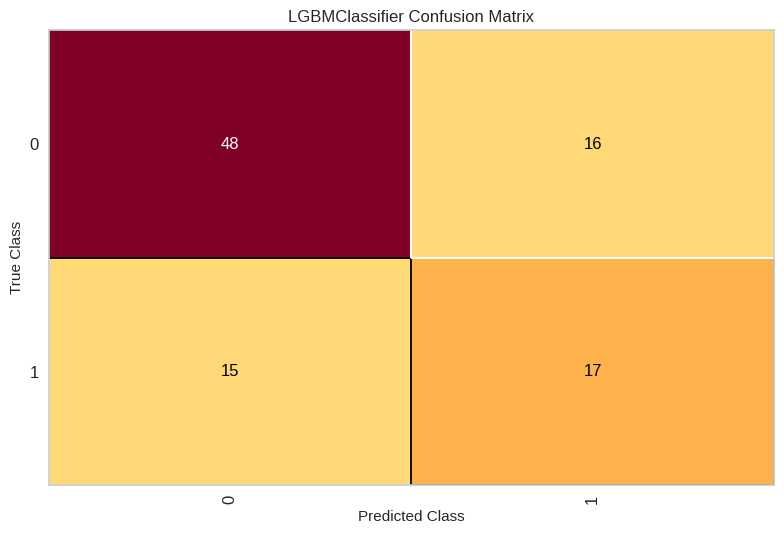

<Axes: title={'center': 'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [91]:
X = df_sopro_percusao.drop(columns=["label_inst", "label_cat_inst", "cat_inst", "instrumento"])
y = df_sopro_percusao.label_cat_inst

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cm = ConfusionMatrix(LGBMClassifier(), classes=[0,1])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

### Sopro e corda

In [93]:
df_sopro_corda = df_cat_inst[df_cat_inst["cat_inst"].isin(["sopro", "corda"])]
df_sopro_corda["label_cat_inst"] = le.fit_transform(df_sopro_corda.cat_inst)


- Tratar Outilers

In [94]:
outilers_sopro_corda = ac.detected_outilers_knn(
    dataframe=df_sopro_corda,
    algorithm='auto', 
    neighbors=5, 
    metric='euclidean'
)

df_sopro_corda = ac.show_outilers(
    dataframe=df_sopro_corda,
    pred=outilers_sopro_corda['predictions']
)

df_sopro_corda

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst,label_cat_inst
1876,sopro,-0.044667,0.260524,0.692127,0.238955,0.029413,0.424056,0.732275,0.106237,0.264656,...,1872.058375,0.862944,2738.513835,-70.011116,-80.000000,0.139929,30932,clarinet,4,1
1878,sopro,0.089747,0.253008,0.299878,0.225017,0.544357,0.164941,0.079692,0.119684,0.194826,...,1999.856294,1.274141,3282.789275,-58.643265,-71.021973,0.176906,39102,clarinet,4,1
1886,sopro,0.002779,0.015584,0.311722,0.319367,0.339069,0.368589,0.345589,0.443560,0.344975,...,3154.871456,1.945904,5838.245903,-44.260166,-62.325306,0.232276,51374,clarinet,4,1
1887,sopro,0.105165,0.011241,0.407080,0.577214,0.610102,0.431792,0.194139,0.107201,0.066060,...,2288.592275,0.987397,5162.173271,-58.093662,-77.751862,0.046046,10185,clarinet,4,1
1888,sopro,0.108679,0.066236,0.484411,0.352953,0.433525,0.316416,0.265250,0.316138,0.292531,...,1992.119222,1.766695,4726.313261,-42.178364,-41.680836,0.041709,9216,clarinet,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7999,corda,0.188614,-0.123051,0.435805,0.078954,0.048469,0.095815,0.166382,0.088318,0.250419,...,1772.864514,1.268380,2945.977004,-76.595161,-80.000000,0.126178,27872,violin,18,0
8016,corda,0.066705,-0.239727,0.177657,0.249958,0.202065,0.227559,0.358576,0.191313,0.535777,...,2049.088272,1.239214,3472.241494,-45.379463,-80.000000,0.128462,28414,violin,18,0
8017,corda,0.096697,-0.279816,0.159033,0.078111,0.079078,0.180735,0.292732,0.125269,0.363708,...,2277.244488,1.186836,3779.127109,-50.537724,-80.000000,0.143759,31806,violin,18,0
8020,corda,0.015595,-0.058762,0.120028,0.238263,0.234643,0.267743,0.228591,0.260930,0.267262,...,3573.542978,1.354204,6552.813508,-43.596504,-73.498703,0.230540,50962,violin,18,0


- Treinamento de Modelo

In [95]:
list_models = np.array([
    LGBMClassifier(),
    XGBClassifier(),
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    MLPClassifier()
])

tm.train_models(
    X= df_sopro_percusao.drop(columns=['instrumento','label_inst', 'label_cat_inst','cat_inst']),
    y= df_sopro_percusao['label_cat_inst'],
    models=list_models
)

Acuracia do modelo LGBMClassifier() do Fold 0: 0.703125
Acuracia do modelo LGBMClassifier() do Fold 1: 0.75
Acuracia do modelo LGBMClassifier() do Fold 2: 0.7301587301587301
Acuracia do modelo LGBMClassifier() do Fold 3: 0.5555555555555556
Acuracia do modelo LGBMClassifier() do Fold 4: 0.49206349206349204
Acuracia do modelo XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, 

{'LGBMClassifier': 0.5655242093042614,
 'XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n              interaction_constraints=None, learning_rate=None, max_bin=None,\n              max_cat_threshold=None, max_cat_to_onehot=None,\n              max_delta_step=None, max_depth=None, max_leaves=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=None, ..': 0.567019682500567,
 'GaussianNB': 0.5682262871188828,
 'KNeighborsClassifier': 0.5675890263228256,
 'DecisionTreeClassifier': 0.5677495014945498,
 'RandomForestClassifier': 0.5687724985952186,
 'Hi

In [96]:
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
print(dictionary)

{'corda': 0, 'sopro': 1}


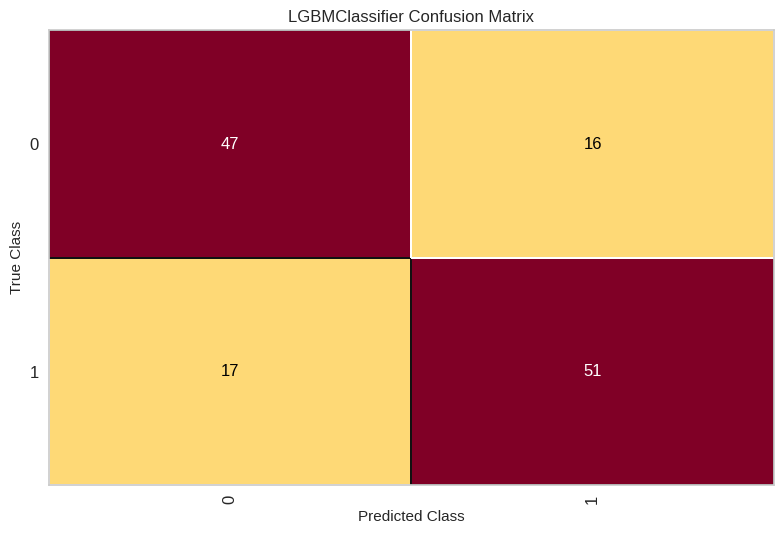

<Axes: title={'center': 'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [97]:
X = df_sopro_corda.drop(columns=["label_inst", "label_cat_inst", "cat_inst", "instrumento"])
y = df_sopro_corda.label_cat_inst

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cm = ConfusionMatrix(LGBMClassifier(), classes=[0,1])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

### Corda Percusão

In [98]:
df_corda_percusao = df_cat_inst[df_cat_inst["cat_inst"].isin(["corda", "percusao"])]
df_corda_percusao["label_cat_inst"] = le.fit_transform(df_corda_percusao.cat_inst)
df_corda_percusao

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst,label_cat_inst
2027,percusao,0.040087,0.116203,0.409334,0.260820,0.298635,0.223068,0.472596,0.682380,0.315802,...,2843.107702,0.915473,6288.444728,-72.321693,-79.942192,0.106036,23418,cymbals,5,1
2028,percusao,0.064332,-0.023445,0.221986,0.318158,0.420399,0.800723,0.699277,0.292424,0.310495,...,2549.517812,1.755609,4183.087002,-47.144733,-65.961197,0.182486,40358,cymbals,5,1
2029,percusao,-0.039875,0.021506,0.597219,0.522248,0.357256,0.306705,0.454092,0.676822,0.459109,...,2543.370274,0.869033,4545.004690,-59.076328,-70.129898,0.152626,33743,cymbals,5,1
2030,percusao,-0.039822,0.028304,0.621655,0.511336,0.348413,0.316168,0.392748,0.568508,0.565586,...,2479.813426,1.396642,5702.476809,-63.114140,-71.209488,0.082574,18250,cymbals,5,1
2031,percusao,0.098013,0.027428,0.383891,0.186740,0.131834,0.186899,0.345623,0.210410,0.242533,...,2037.566496,1.731518,4412.483063,-56.386051,-59.750889,0.079232,17508,cymbals,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8019,corda,0.051950,0.691044,0.773323,0.582712,0.532384,0.274606,0.127275,0.109617,0.158079,...,658.017342,1.227272,1367.932950,-35.302883,-68.164001,0.019043,4212,violin,18,0
8020,corda,0.015595,-0.058762,0.120028,0.238263,0.234643,0.267743,0.228591,0.260930,0.267262,...,3573.542978,1.354204,6552.813508,-43.596504,-73.498703,0.230540,50962,violin,18,0
8021,corda,0.093624,-0.031124,0.253249,0.321181,0.309254,0.265595,0.265015,0.155659,0.181344,...,1421.358194,1.173742,2751.578644,-48.512993,-66.277359,0.065123,14407,violin,18,0
8022,corda,0.004588,-0.009204,0.124913,0.174113,0.185558,0.169614,0.149416,0.075544,0.081894,...,3720.081212,1.332893,6207.732687,-37.720039,-72.552101,0.241853,53491,violin,18,0


- Tratamento Outilers

In [100]:
outilers_corda_percusao  = ac.detected_outilers_knn(
    dataframe=df_corda_percusao,
    algorithm='auto', 
    neighbors=5, 
    metric='euclidean'
)

df_corda_percusao = ac.show_outilers(
    dataframe=df_corda_percusao,
    pred=outilers_corda_percusao['predictions']
)

df_corda_percusao

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst,label_cat_inst
2058,percusao,0.028724,0.119361,0.387632,0.360637,0.641758,0.430467,0.488429,0.566602,0.417376,...,3368.580434,1.101028,7120.545651,-64.049034,-75.085358,0.179711,39714,cymbals,5,1
2066,percusao,0.067263,-0.079658,0.400289,0.414243,0.519233,0.403937,0.590723,0.326989,0.475230,...,3813.025950,1.273033,7134.060110,-47.323631,-62.697948,0.257473,56977,cymbals,5,1
2080,percusao,-0.028268,0.020594,0.308341,0.539134,0.486185,0.370537,0.365475,0.277279,0.237507,...,5631.779972,1.150056,8727.017531,-66.101967,-79.368797,0.486816,107670,cymbals,5,1
2084,percusao,0.090227,0.001803,0.181475,0.215828,0.223079,0.230837,0.477740,0.319292,0.496053,...,2887.785890,1.069310,5327.569254,-51.677456,-71.216888,0.188245,41621,cymbals,5,1
2087,percusao,0.000423,0.008728,0.315313,0.329236,0.318093,0.291647,0.358462,0.355331,0.340839,...,4034.598255,2.311115,7370.300831,-48.193481,-79.993744,0.275738,60975,cymbals,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7985,corda,0.096277,-0.052381,0.191616,0.350705,0.468479,0.435073,0.212301,0.080977,0.115835,...,4522.094860,1.526853,7486.435241,-40.565266,-63.035709,0.295218,65285,violin,18,0
7999,corda,0.188614,-0.123051,0.435805,0.078954,0.048469,0.095815,0.166382,0.088318,0.250419,...,1772.864514,1.268380,2945.977004,-76.595161,-80.000000,0.126178,27872,violin,18,0
8017,corda,0.096697,-0.279816,0.159033,0.078111,0.079078,0.180735,0.292732,0.125269,0.363708,...,2277.244488,1.186836,3779.127109,-50.537724,-80.000000,0.143759,31806,violin,18,0
8020,corda,0.015595,-0.058762,0.120028,0.238263,0.234643,0.267743,0.228591,0.260930,0.267262,...,3573.542978,1.354204,6552.813508,-43.596504,-73.498703,0.230540,50962,violin,18,0


- Treinamento de Modelos

In [101]:
list_models = np.array([
    LGBMClassifier(),
    XGBClassifier(),
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    MLPClassifier()
])

tm.train_models(
    X= df_sopro_corda.drop(columns=['instrumento','label_inst', 'label_cat_inst','cat_inst']),
    y= df_sopro_corda['label_cat_inst'],
    models=list_models
)

Acuracia do modelo LGBMClassifier() do Fold 0: 0.5862068965517241
Acuracia do modelo LGBMClassifier() do Fold 1: 0.5862068965517241
Acuracia do modelo LGBMClassifier() do Fold 2: 0.7586206896551724
Acuracia do modelo LGBMClassifier() do Fold 3: 0.6666666666666666
Acuracia do modelo LGBMClassifier() do Fold 4: 0.3953488372093023
Acuracia do modelo XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estima

{'LGBMClassifier': 0.5706205151440346,
 'XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n              interaction_constraints=None, learning_rate=None, max_bin=None,\n              max_cat_threshold=None, max_cat_to_onehot=None,\n              max_delta_step=None, max_depth=None, max_leaves=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=None, ..': 0.5715194840795709,
 'GaussianNB': 0.5705947063487135,
 'KNeighborsClassifier': 0.5700981195551984,
 'DecisionTreeClassifier': 0.5702571183204155,
 'RandomForestClassifier': 0.5709989719827944,
 'H

- Matriz de confusão

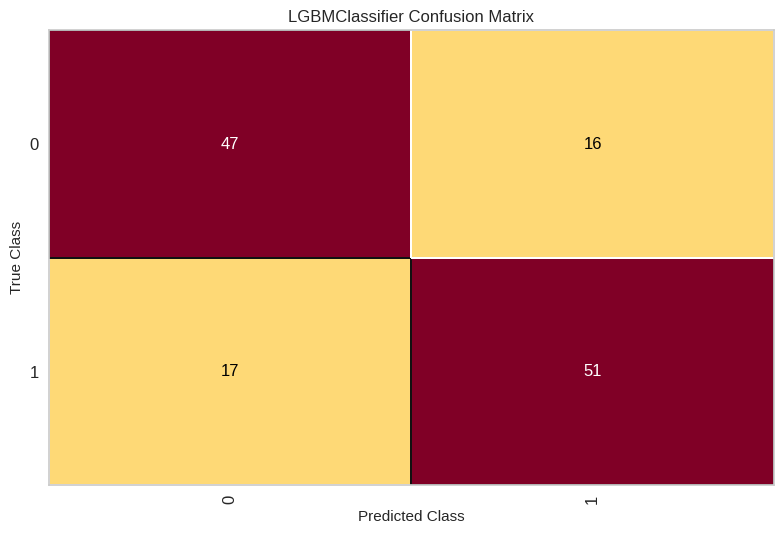

<Axes: title={'center': 'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [102]:
X = df_sopro_corda.drop(columns=["label_inst", "label_cat_inst", "cat_inst", "instrumento"])
y = df_sopro_corda.label_cat_inst

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cm = ConfusionMatrix(LGBMClassifier(), classes=[0,1])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()